# THE WAR AGAINST HEART ARRHYTHMIA

In [109]:
import numpy as np
from os import listdir, mkdir, system
from os.path import isfile, isdir, join, exists
import math
import pandas as pd
import csv
import wfdb
import scipy.signal
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.fftpack import fft, ifft
from sklearn import preprocessing
from scipy.signal import argrelextrema
from scipy.signal import argrelmax
from numpy import where
from collections import deque
from arch.unitroot import VarianceRatio
import statsmodels.graphics.tsaplots as st
from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
import itertools as it
from itertools import combinations
from scipy.signal import butter, filtfilt
import glob

## Preprocessing:

1. Subtract the mean from the data
2. Five order moving average filtering
3. high pass filtering with fc = 1 Hz (driftsuppression)
4. low-pass Butterworth filtering with fc = 30 Hz
5. Noise, asystole and low-quality episode segments were removed according to the corresponding annotation labels. 
6. Only the first channels of the MITDB and the VFDB have been considered to avoid dependency of samples during the learning process.

# Loading and viewing the data

In [114]:
dat_files=glob.glob('C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Data_thesis/CUDB/*.dat') #Get list of all .dat files in the current folder
df=pd.DataFrame(data=dat_files)
df.to_csv("files_list.csv",index=False,header=None) #Write the list to a CSV file
files=pd.read_csv("files_list.csv",header=None)

for i in range(1,len(files)+1):
	recordname=str(files.iloc[[i]])
	print(recordname[:-4])
	recordname_new=recordname[-7:-4] #Extracting just the filename part (will differ from database to database)
	record = wfdb.rdsamp(recordname_new) # rdsamp() returns the signal as a numpy array  
	record=np.asarray(record[0])
	path=recordname_new+".csv"
	np.savetxt(path,record,delimiter=",") #Writing the CSV for each record
	print("Files done: %s/%s"% (i,len(files)))

print("\nAll files done!")	

                                                   0
1  C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Wor


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\ahmad\\Desktop\\UC3M\\Thesis\\Python_Workspace\\Code_thesis\\Wor.hea'

In [106]:
dir = 'C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Data_thesis/CUDB/'#'mitdb/'
#Create folder
dir_out = dir + 'csv/'
if not exists(dir_out):
	mkdir(dir_out)

records = [f for f in listdir(dir) if isfile(join(dir, f)) if(f.find('.dat') != -1)]
#print records

for r in records:

	command = 'rdsamp -r ' + dir + r[:-4] + ' -c -H -f 0 -v >' + dir_out + r[:-4] + '.csv'
	print(command)
	system(command)

	command_annotations = 'rdann -r ' + dir + r[:-4] +' -f 0 -a atr -v >' + dir_out + r[:-4] + '.ann'
	print(command_annotations)
	system(command_annotations)

rdsamp -r C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Data_thesis/CUDB/cu01 -c -H -f 0 -v >C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Data_thesis/CUDB/csv/cu01.csv
rdann -r C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Data_thesis/CUDB/cu01 -f 0 -a atr -v >C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Data_thesis/CUDB/csv/cu01.ann
rdsamp -r C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Data_thesis/CUDB/cu02 -c -H -f 0 -v >C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Data_thesis/CUDB/csv/cu02.csv
rdann -r C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Data_thesis/CUDB/cu02 -f 0 -a atr -v >C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Data_thesis/CUDB/csv/cu02.ann
rdsamp -r C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Data_thesis/CUDB/cu03 -c -H -f 0 -v >C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Data_thesis/CUDB/csv/cu03.csv
rdann -r C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Data_thesis/CUDB/cu03 -f 0 -a atr 

rdann -r C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Data_thesis/CUDB/cu26 -f 0 -a atr -v >C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Data_thesis/CUDB/csv/cu26.ann
rdsamp -r C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Data_thesis/CUDB/cu27 -c -H -f 0 -v >C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Data_thesis/CUDB/csv/cu27.csv
rdann -r C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Data_thesis/CUDB/cu27 -f 0 -a atr -v >C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Data_thesis/CUDB/csv/cu27.ann
rdsamp -r C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Data_thesis/CUDB/cu28 -c -H -f 0 -v >C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Data_thesis/CUDB/csv/cu28.csv
rdann -r C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Data_thesis/CUDB/cu28 -f 0 -a atr -v >C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Data_thesis/CUDB/csv/cu28.ann
rdsamp -r C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Data_thesis/CUDB/cu29 -c -H -f 0 

In [107]:
MIT_data = pd.read_csv("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Data_thesis/cudb/csv/cu01.csv")
MIT_data = MIT_data.iloc[:,1:3].astype("float")

EmptyDataError: No columns to parse from file

In [66]:
MIT_data = pd.read_csv("C:/Users/ahmad/Desktop/UC3M/Thesis/Python_Workspace/Data_thesis/mitbih_database/102.csv")
MIT_data = MIT_data.iloc[:,1:3].astype("float")

In [82]:
MIT_data_col1 = MIT_data.iloc[:,0]
MIT_data_first = MIT_data_col1.astype("float")
MIT_data_first.shape

AttributeError: 'bytes' object has no attribute 'iloc'

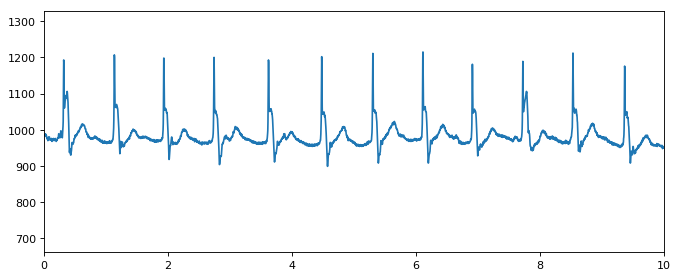

In [69]:
fs = 360
time = np.arange(MIT_data_first.size)/fs
figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.xlim((0, 10))
#plt.ylim((930,1050))
plt.plot(time,MIT_data_first)

# Step 1: Subtract the mean

In [6]:
mean1 = np.mean(MIT_data.iloc[:,0])
mean2 = np.mean(MIT_data.iloc[:,1])

print(mean1)
print(mean2)

974.8292461538462
1026.5165523076923


In [7]:
MIT_data.iloc[:,0] = MIT_data.iloc[:,0] - mean1

In [8]:
MIT_data.iloc[:,1] = MIT_data.iloc[:,1] - mean2

# Step 2: Five order moving average filtering

In [9]:
def moving_average(l, N):
    sum = 0
    result = list( 0 for x in l)
 
    for i in range( 0, N ):
        sum = sum + l[i]
        result[i] = sum / (i+1)
 
    for i in range( N, len(l) ):
        sum = sum - l[i-N] + l[i]
        result[i] = sum / N
 
    return result

In [10]:
MIT_data.iloc[:,0] = moving_average(MIT_data.iloc[:,0],5)

In [11]:
MIT_data.iloc[:,1] = moving_average(MIT_data.iloc[:,1],5)

In [12]:
MIT_data = MIT_data.astype("float")

(0, 10)

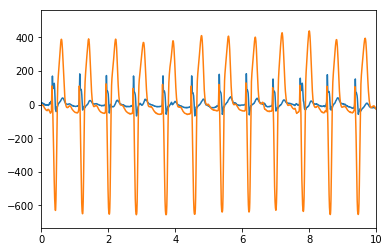

In [13]:
plt.plot(time,MIT_data)
plt.xlim(0,10)

# Step 3: High Pass Filtering with f = 1 Hz (Drift Suppression)

In [14]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [15]:
fs = 360
cutoff = 1
order = 5
MIT_conditioned_signal = butter_highpass_filter(MIT_data.iloc[:,0], cutoff, fs, order)

In [16]:
MIT_conditioned_signal

array([-4.23202213, -4.31511506, -4.39902854, ...,  3.29638229,
        1.65692434,  7.8239824 ])

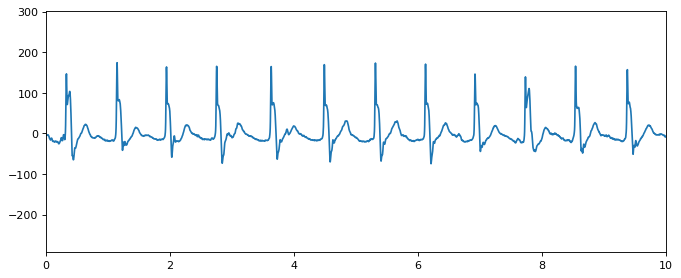

In [17]:
#time = np.arange(MIT_conditioned_signal.size)
figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.xlim((0, 10))
#plt.ylim((930,1050))
plt.plot(time,MIT_conditioned_signal)

# Step 4: low-pass Butterworth filtering with fc = 30 Hz

In [18]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [19]:
order = 5
fs = 30
cutoff = 1

MIT_signal = butter_lowpass_filter(MIT_conditioned_signal, cutoff, fs, order)

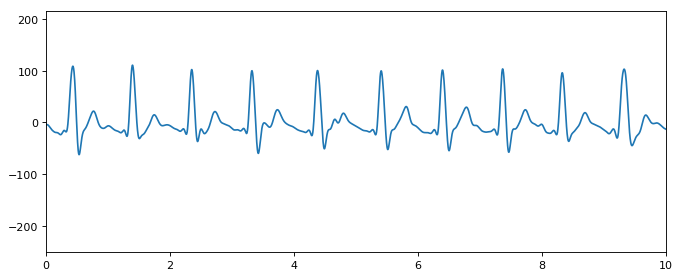

In [20]:
fs=30
time = np.arange(MIT_signal.size)/fs
time = time/10
figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.xlim((0, 10))
#plt.ylim((930,1050))
plt.plot(time,MIT_signal)

## Parameter 1: TCI

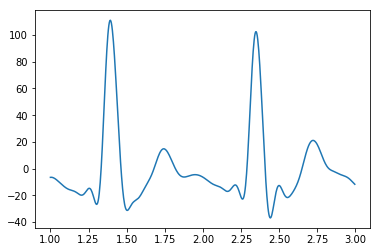

In [21]:
MIT_signal.size
time.size
time[300]
time[600]
plt.plot(time[300:900],MIT_signal[300:900])

In [22]:
def TCI(start,finish,MIT_signal):
    threshold = np.arange(finish-start).astype("float")
    m = start
    n = start
    i=0
    while(i < threshold.size):
        threshold[i]=0.2*np.amax(MIT_signal[int(np.ceil(m*600)):int(np.ceil((m+1)*600))])
        i+=1
        m+=1
    print("Threshold values(in order) = ",threshold)
    TCI = []
    while(start < finish):
        N = 2 ##Try to see how many maxes
        MIT1 = MIT_signal[int(np.floor((n-1/2)*600)):int(np.ceil(n*600))]
        MIT2 = MIT_signal[int(np.ceil(n*600)):int(np.ceil((n+(1/2))*600))]
        MIT3 = MIT_signal[int(np.ceil((n+1.4)*600)):int(np.ceil((n+2)*600))]
        MIT4 = MIT_signal[int(np.ceil((n+2)*600)):int(np.ceil((n+2.5)*600))]
        
        lis = []
        k=0
        while(k<len(MIT1)):
            if MIT1[k] <= -threshold[0]:
                MIT1 = MIT1[k:len(MIT1)]
                break   
            k+=1
        k=0
        while(k<len(MIT2)):
            if MIT2[k] >= threshold[0]:
                MIT2 = MIT2[0:len(MIT2)-k]
                break
            k+=1
        k=0 
        while(k<len(MIT3)):
            if MIT3[k] <= -threshold[0]:
                MIT3 = MIT3[k:len(MIT3)]
                break
            k+=1
        k=0
        while(k<len(MIT4)):
            if MIT4[k] >= threshold[0]:
                MIT4 = MIT4[0:len(MIT4)-k]
                break
            k+=1
            
        t1 = MIT1.size
        t2 = MIT2.size  #conversion doesn't matter
        t3 = MIT3.size
        t4 = MIT4.size
        
        x = t2/(t1+t2)
        y = t3/(t3+t4)
        
        l = 1000/(N-1+x+y)
        n+=1
        TCI.append(l)
        start+=1
        
    print("TCI values(in order) = ",TCI)

In [23]:
TCI(4,10,MIT_signal)

Threshold values(in order) =  [20.66009243 19.9697147  20.00373254 20.1099789  21.01493955 22.94288684]
TCI values(in order) =  [491.423787597919, 509.04156306774814, 509.5522448620758, 513.6285776491851, 492.5217435825232, 489.48036647717527]


## Parameter 2: ACF

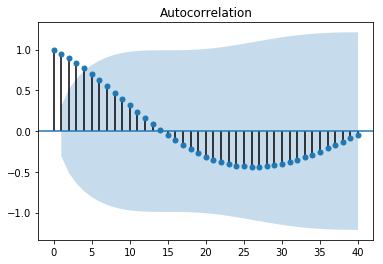

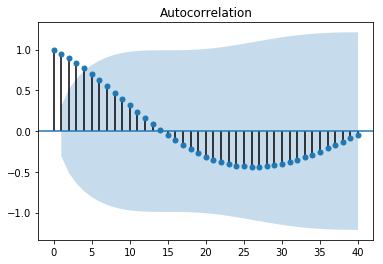

In [24]:
ser = acf(MIT_signal[0:2000],6)
st.plot_acf(ser)

In [25]:
ser

array([ 1.        ,  0.99710861,  0.98748333,  0.97124027,  0.94857714,
        0.91976956,  0.8851659 ,  0.8451808 ,  0.80028763,  0.75100996,
        0.69791242,  0.64159094,  0.58266286,  0.52175699,  0.4595038 ,
        0.39652607,  0.33343009,  0.27079754,  0.20917825,  0.14908384,
        0.09098241,  0.0352942 , -0.01761171, -0.06741968, -0.11386882,
       -0.15675337, -0.19592223, -0.23127774, -0.2627737 , -0.29041281,
       -0.3142436 , -0.33435682, -0.35088158, -0.36398106, -0.37384811,
       -0.38070063, -0.38477683, -0.38633056, -0.38562657, -0.38293591,
       -0.37853146])

In [26]:
vr = VarianceRatio(ser,6)
vr.overlap=False
print(vr)

     Variance-Ratio Test Results     
Test Statistic                  8.227
P-value                         0.000
Lags                                6
-------------------------------------

Computed with non-overlapping blocks


D:\Anaconda3\lib\site-packages\arch\unitroot\unitroot.py:1485: InvalidLengthWarning: 
The length of y is not an exact multiple of 6, and so the final
4 observations have been dropped.

  InvalidLengthWarning)


## Parameter 3: VF Filter

In [27]:
def get_points(signal,m):
    i=1
    x=0
    y=0
    while i <= m:
        x = x + np.absolute(signal[i])
        y = y + np.absolute(signal[i]-signal[i-1])
        i+=1
    N = np.floor(np.pi*(x/y)+0.5)
    return N

def leakage(signal,N,n,m):
    i=n
    x=0
    y=0
    while i <= m:
        x = x + np.absolute(signal[i]+signal[i-N])
        y = y + (np.absolute(signal[i])+np.absolute(signal[i-N]))
        i+=1
    l = x/y
    return l
    

In [28]:
get_points(MIT_signal,600)

49.0

In [29]:
leakage(MIT_signal,int(get_points(MIT_signal,600)),0,300)

0.5689274778134069

## Parameter 4: Spectral Algorithm

In [30]:
Ham = MIT_signal*np.hamming(650000)

(-25, 25)

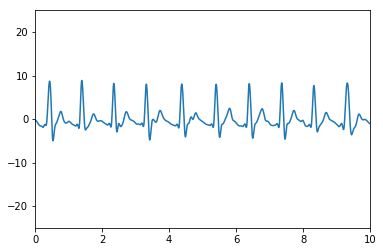

In [31]:
plt.plot(time,Ham)
plt.xlim(0,10)
plt.ylim(-25,25)

In [32]:
freqs, psd = scipy.signal.welch(MIT_signal, fs=25, window='hamming')

In [33]:
fourier = scipy.fft(Ham)

In [34]:
fourier

array([-30.31516534+0.j        , -30.31961976-0.00918413j,
       -30.32176559-0.02489656j, ..., -30.30445413+0.05804835j,
       -30.32176559+0.02489656j, -30.31961976+0.00918413j])

D:\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0, 10)

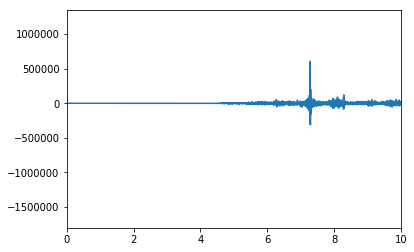

In [35]:
plt.plot(time,fourier)
plt.xlim(0,10)

In [36]:
def fourier_abs(fourier):
    j=0
    for i in fourier:
        fourier[j] = np.absolute(i.real)+np.absolute(i.imag)
        j+=1
    return fourier

In [37]:
fourier_2 = fourier_abs(fourier)

In [38]:
fourier_2

array([30.31516534+0.j, 30.3288039 +0.j, 30.34666215+0.j, ...,
       30.36250248+0.j, 30.34666215+0.j, 30.3288039 +0.j])

(0, 100)

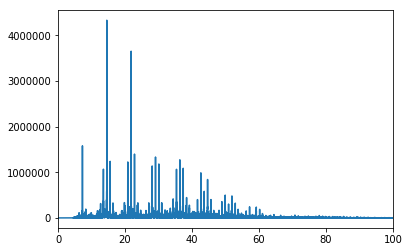

In [39]:
plt.plot(time,fourier_2)
plt.xlim(0,100)

In [40]:
freq_1 = 0.5
freq_2 = 9

time_1 = 1/9
time_2 = 1/0.5

range1 = int(np.ceil(time_1*300))
range2 = int(np.floor(time_2*300))

fourier_3 = fourier_2[range1:range2]

In [41]:
m = np.amax(fourier_3)
f = fourier_3.tolist()
print(f.index(m))
print(m)

534
(39.20215676186343+0j)


In [42]:
time_max_amp = f.index(m)/300 ## in seconds
God_of_War = 1/time_max_amp
God_of_War

0.5617977528089888

In [43]:
def amp_maxsetter(fourier,m):
    j = 0
    for i in fourier:
        if i < 0.05*m:
            fourier[j]=0
        j+=1
    return fourier

In [44]:
fourier_final = amp_maxsetter(fourier_2,m)
fourier_final

array([30.31516534+0.j, 30.3288039 +0.j, 30.34666215+0.j, ...,
       30.36250248+0.j, 30.34666215+0.j, 30.3288039 +0.j])

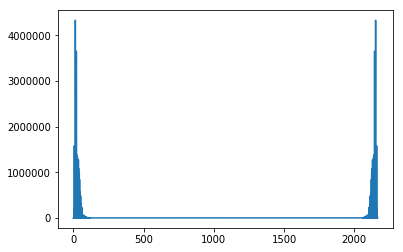

In [45]:
plt.plot(time,fourier_final)

In [46]:
def moment_calc(fourier,omega,jmax):
    j=0
    s=0
    fft = fourier[0:int(np.amin([20*omega,100]))]
    while j <= jmax:
        freq = 300/j   ##fix time
        m = 1/omega
        s = s + (m*freq)
        j+=1

In [47]:
# moment_calc(fourier_final,God_of_War,f.index(m))

## Parameter 5: Complexity Measure Algorithm

In [48]:
nurgle = MIT_signal[0:2400]
meanbean = np.mean(nurgle)
nurgle = nurgle - meanbean
Vp = np.amax(nurgle)
Vn = np.amin(nurgle)

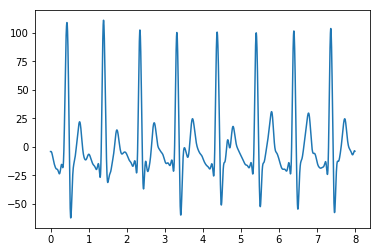

In [49]:
plt.plot(time[0:2400],nurgle)

In [50]:
def Td(Vp,Vn,nurgle):
    pc = 0
    nc = 0
    for i in nurgle:
        if i>0 and i<0.1*Vp:
            pc+=1
        elif i<0 and i>0.1*Vn:
            nc+=1
    if pc+nc < 0.4*len(nurgle):
        T = 0
    elif pc<nc:
        T = 0.2*Vp
    elif pc>nc:
        T = 0.2*Vn
    return T

In [51]:
Threshold = Td(Vp,Vn,nurgle)
Threshold

0

In [52]:
def binary_comp(Threshold,nurgle):
    s = []
    for i in nurgle:
        if i<Threshold:
            s.append(0)
        else:
            s.append(1)
    return np.array(s)

In [53]:
binary = binary_comp(Threshold,nurgle)
binary

array([0, 0, 0, ..., 0, 0, 0])

In [54]:
def substrings(string):
    length = len(string)
    alist = []
    for i in range(length):
        for j in range(i,length):
            alist.append(string[i:j + 1]) 
    return alist

def complexity(binary):
    cn = 1
    S = [binary[0]]
    Q = [binary[1]]
    m = 0
    while 2 < 3:
        con = S+Q
        con = con[:-1]
        C = substrings(con)
        if Q not in C:
            m = 0
            S = S+Q
            if len(S) == len(binary)-1:
                cn+=1
                break
            Q = [binary[len(S)]]
            cn+=1
        elif Q in C:
            k = len(S)+m
            if k < len(binary):
                Q = Q+[binary[len(S)+m]]
                m+=1
            else:
                break
    return cn

In [55]:
#cn = complexity(binary[0:2400])
#cn

In [56]:
bn = len(binary)/(math.log2(len(binary)))

In [57]:
complexity_measure = cn/bn
complexity_measure

NameError: name 'cn' is not defined

## Parameter 6: Standard Exponential Algorithm

In [ ]:
def exp_algthm(t,signal,Tau):
    M = np.amax(signal)
    tm = (np.where(MIT_signal==M))[0]/300
    exp_part = np.exp((-1*np.absolute(t-tm))/Tau)
    curve = M*exp_part
    
    plt.plot(t,signal)
    plt.plot(t,curve)
    idx = np.argwhere(np.diff(np.sign(signal-curve))).flatten()
    plt.plot(t[idx],signal[idx],'ro')
    
    Time_length = len(signal)/300
    int_num = len(idx)
    N = (int_num/Time_length)*60
    return N

In [ ]:
exp_algthm(time[4800:7200],MIT_signal[4800:7200],3)

## Parameter 7: Modified Exponential Algorithm

In [144]:
def MEA(t,signal,Tau):
    index_M = argrelextrema(signal,np.greater)
    index_realM = []
    for j in index_M[0]: 
        if signal[j] > 0.5*np.amax(signal):
            index_realM.append(j)
    tm = np.array(index_realM)/300
    real_curve = [1.0]*len(t)
    k = 0
    for j in index_realM:
        Mj = MIT_signal[j]
        tmj = tm[k]
        if k <= len(tm)-2:
            tmj1 =tm[k+1]
        else: 
            tmj1 = 2200
        exp_part = np.exp((-1*(t-tmj))/Tau)
        curve = Mj*exp_part
        idx = np.argwhere(np.diff(np.sign(signal-curve))).flatten()
        l = 0
        for i in t: 
            tc = np.array(idx)/300
            tcj = tc[-1]
            if tmj <= i <= tcj:
                real_curve[l]=(curve[np.where(t == i)].item())
            elif tcj<= i <= tmj1:
                real_curve[l]=(signal[np.where(t == i)].item())
            l+=1
        k+=1
    plt.figure(figsize=(20,10))
    plt.plot(t,signal)
    plt.plot(t,real_curve)
    idx = np.argwhere(np.diff(np.sign(signal-real_curve))).flatten()
    plt.plot(t[idx],signal[idx],'ro')
    
    numberofint = len(idx)
    Time_length = len(signal)/300
    N = numberofint/Time_length
    return N*60

300.0

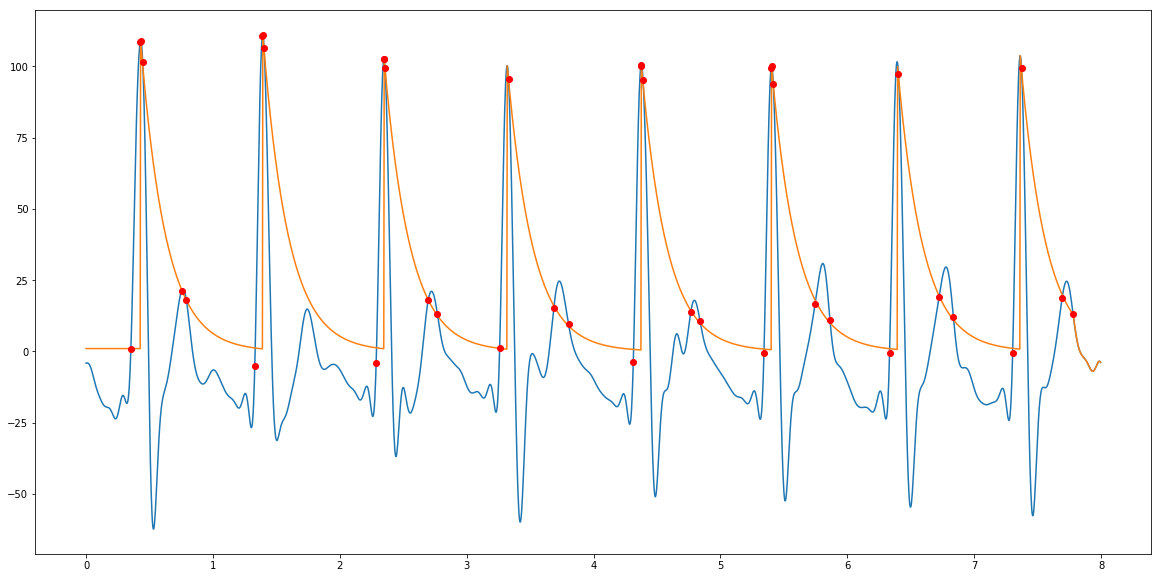

In [145]:
MEA(time[0:2400],MIT_signal[0:2400],0.2)

In [ ]:
index_M = argrelextrema(signal, np.greater)
tm = np.array(index_M[0])/300
tm

In [ ]:
np.amax(time)

In [ ]:
i_m = argrelextrema(signal,np.greater)


In [122]:
(15/8)*60

112.5